In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

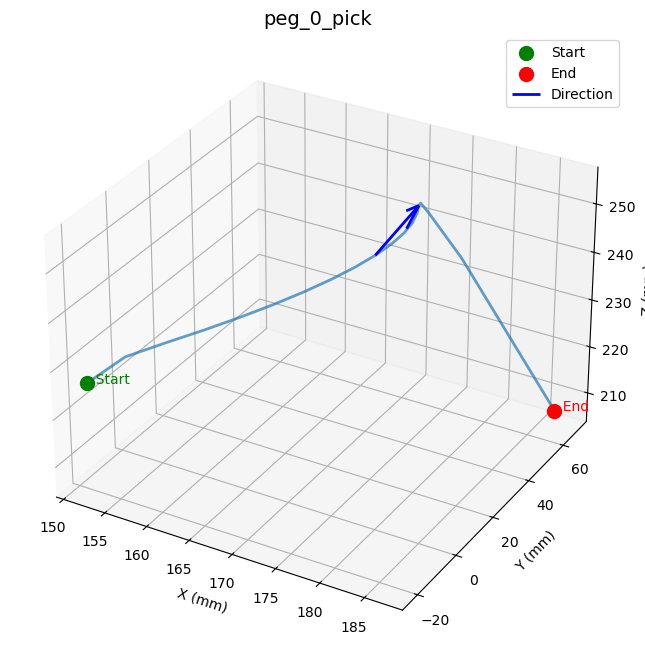

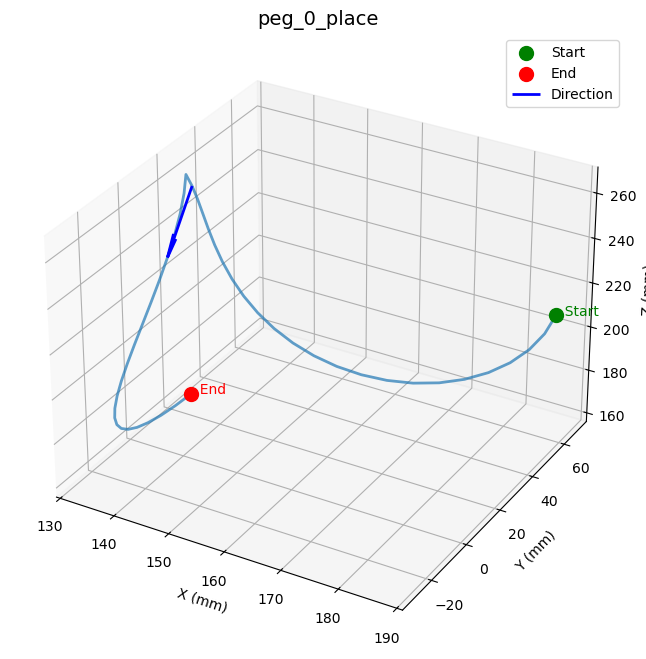

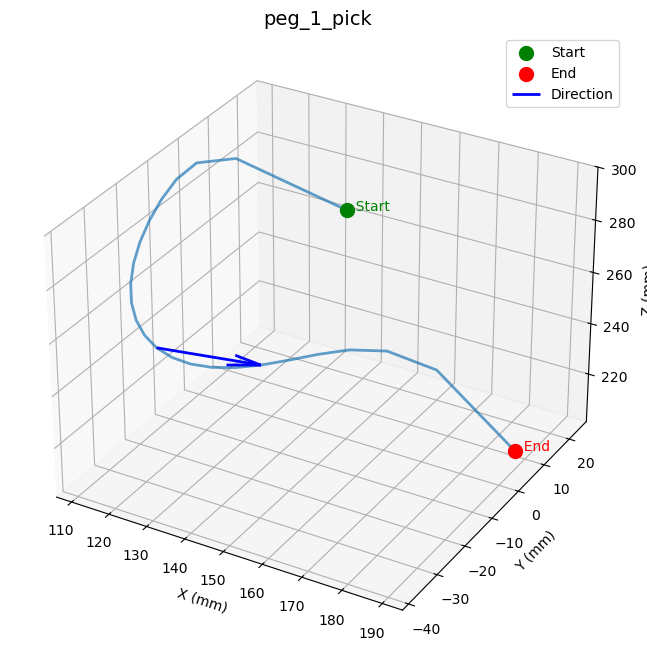

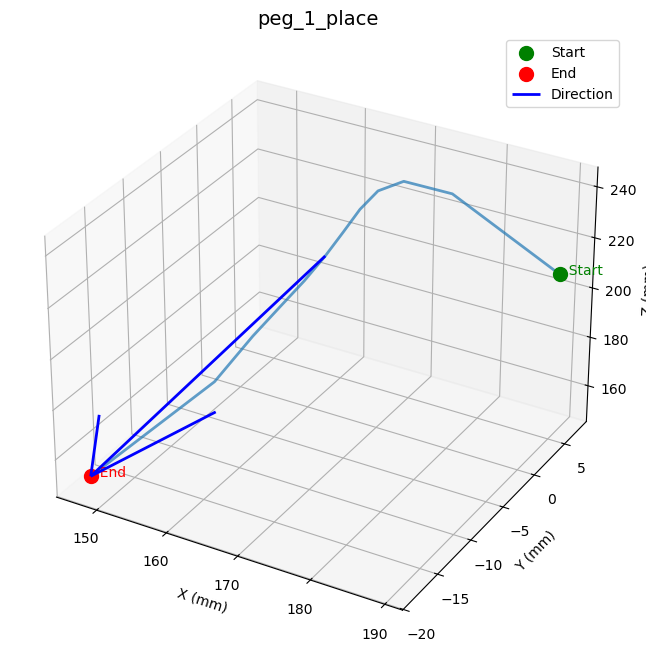

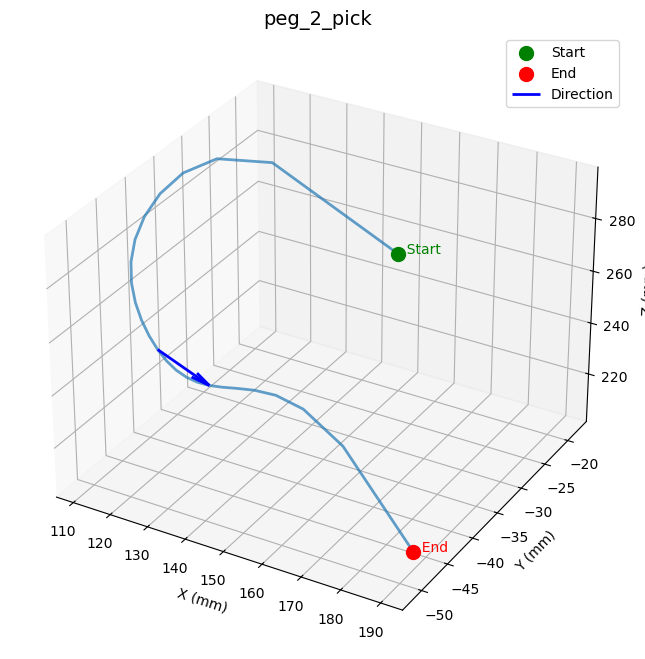

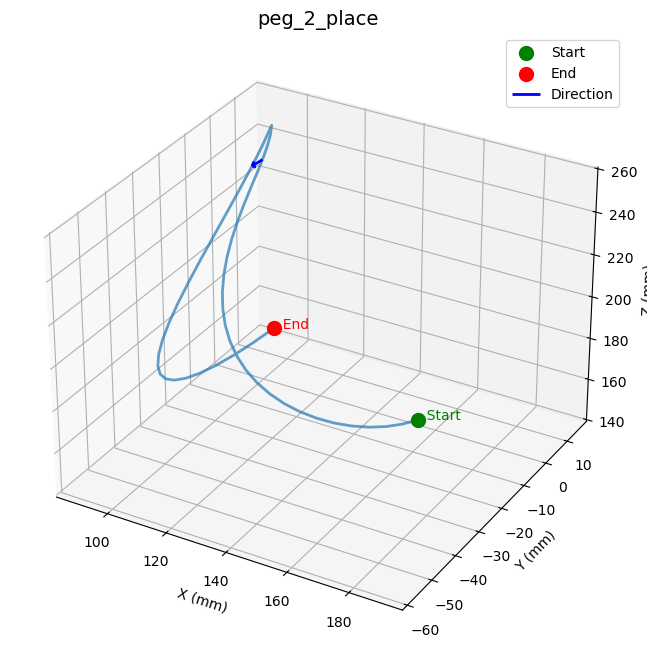

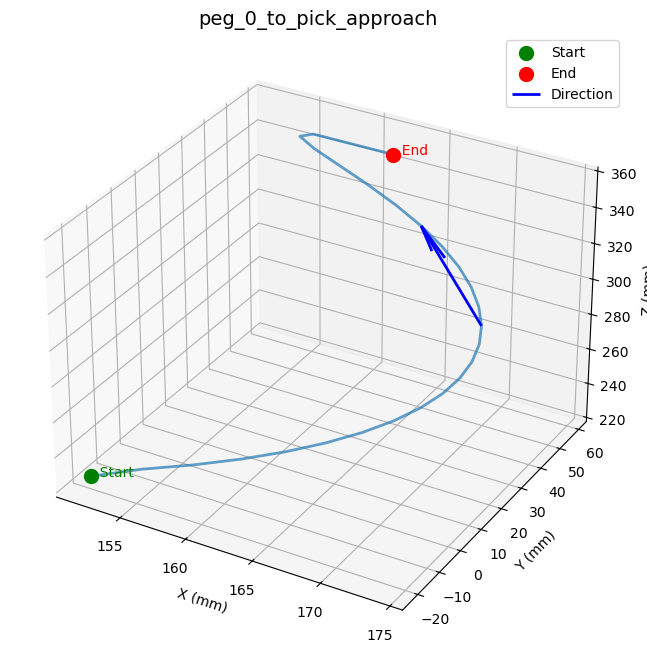

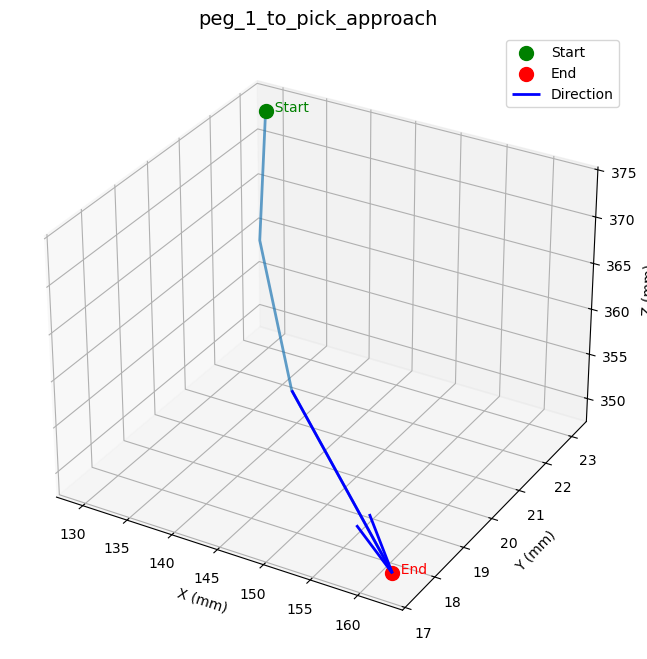

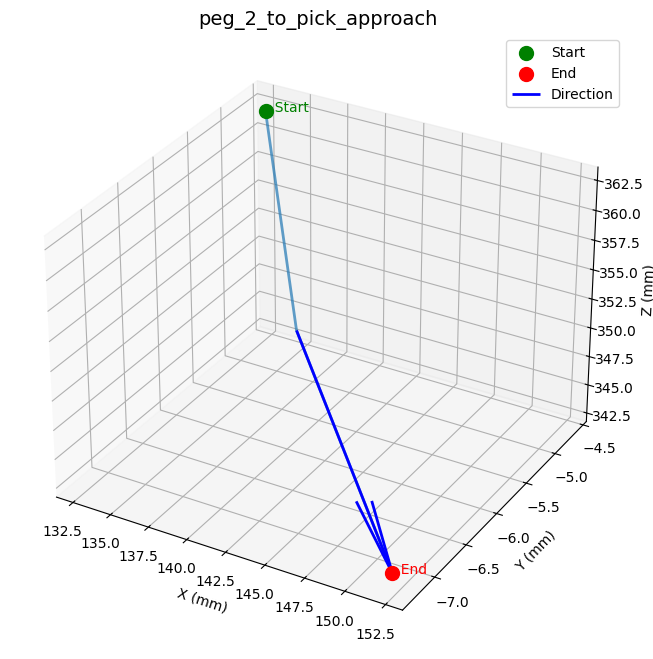

In [ ]:
# load mission

# Update the path below to the correct location of your mission file
mission_path = 'mission_simple.json'  # Use mission_simple.json for new format
try:
    with open(mission_path) as f:
        mission = json.load(f)
    print(f"✓ Loaded mission with {len(mission['pegs'])} peg(s)")
except FileNotFoundError:
    print(f"❌ File not found: {mission_path}")
    print("Available mission files:")
    for f in os.listdir('.'):
        if f.endswith('.json'):
            print(f"  - {f}")
    raise
except json.JSONDecodeError as e:
    print(f"❌ JSON parsing error: {e}")
    raise

# FK function from Peg_Challenge_Group_5? Reimplement minimal FK using DH numeric
DH_PARAMS = [
    (0.049,  0.0,        135.926, 0.0),
    (0.0,    -np.pi/2,   0.0,     -np.pi/2),
    (99.973, 0.0,        0.0,     0.0),
    (10.012, -np.pi/2,   107.011, 0.0),
    (0.003,  np.pi/2,    0.006,   0.0),
    (0.054,  -np.pi/2,   64.973,  0.0)
]

def fk(q):
    q_rad = np.radians(q)
    T = np.eye(4)
    for i,(a,alpha,d,theta_offset) in enumerate(DH_PARAMS):
        th = q_rad[i] + theta_offset
        ct,st = np.cos(th), np.sin(th)
        ca,sa = np.cos(alpha), np.sin(alpha)
        T_i = np.array([
            [ct, -st, 0, a],
            [st*ca, ct*ca, -sa, -sa*d],
            [st*sa, ct*sa, ca, ca*d],
            [0,0,0,1]
        ])
        T = T @ T_i
    return T[:3,3]

# Check if mission has planned_paths
if 'planned_paths' not in mission:
    print("❌ No planned paths found in mission file")
    print("   Run planning first: python Peg_Challenge_Group_5.py")
    print("   Then select 'Generate motion plans'")
else:
    print(f"✓ Found {len(mission['planned_paths'])} planned paths")
    
    # Extract all paths (new format uses different naming)
    paths = mission['planned_paths']
    
    print(f"\nAvailable paths:")
    for name in paths.keys():
        print(f"  - {name}")
    
    # Plot each path
    for name, path in paths.items():
        if 'waypoints' not in path:
            print(f"⚠️  Skipping {name}: no waypoints")
            continue
            
        pts = np.array([fk(wp) for wp in path['waypoints']])
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot the path
        ax.plot(pts[:,0], pts[:,1], pts[:,2], linewidth=2, alpha=0.7, label='Path')
        
        # Mark start position (green)
        ax.scatter(pts[0,0], pts[0,1], pts[0,2], c='green', s=100, marker='o', label='Start')
        ax.text(pts[0,0], pts[0,1], pts[0,2], '  Start', fontsize=10, color='green')
        
        # Mark end position (red)
        ax.scatter(pts[-1,0], pts[-1,1], pts[-1,2], c='red', s=100, marker='o', label='End')
        ax.text(pts[-1,0], pts[-1,1], pts[-1,2], '  End', fontsize=10, color='red')
        
        # Add direction arrow (from midpoint towards end)
        if len(pts) > 10:
            mid_idx = len(pts) // 2
            arrow_start = pts[mid_idx]
            arrow_end = pts[mid_idx + 5] if mid_idx + 5 < len(pts) else pts[-1]
            arrow_vec = arrow_end - arrow_start
            ax.quiver(arrow_start[0], arrow_start[1], arrow_start[2],
                      arrow_vec[0], arrow_vec[1], arrow_vec[2],
                      color='blue', arrow_length_ratio=0.3, linewidth=2, label='Direction')
        
        ax.set_title(f"{name}\n({len(pts)} waypoints)", fontsize=14)
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_zlabel('Z (mm)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()
